В этой части проекта вам нужно написать несколько SQL-запросов в Jupyter Notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'user', # имя пользователя
    'pwd': 'pwd', # пароль
    'host': 'host',
    'port': 'port', # порт подключения
    'db': 'db' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT Date_trunc('month', creation_date) :: DATE AS month_date,
       SUM(views_count) AS total_views
FROM   stackoverflow.posts
WHERE  parent_id = 0
GROUP  BY month_date
ORDER  BY total_views DESC 
'''

# выполните запрос
pd.read_sql_query(query, con=engine)

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

# напишите ваш ответ здесь
Данные отличаются, связанно с запуском stackoverflow в сентябре

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [7]:
# напишите запрос
query = '''
SELECT display_name,
       Count(1)
FROM   stackoverflow.users
WHERE  id IN (SELECT u.id
              FROM   stackoverflow.posts pt
                     LEFT JOIN stackoverflow.users u
                            ON u.id = pt.user_id
              WHERE  parent_id <> 0
                     AND pt.creation_date - u.creation_date < '1 months'
              GROUP  BY u.id
              HAVING Count(1) > 100)
GROUP  BY display_name
ORDER  BY display_name 
'''

# выполните запрос
pd.read_sql_query(query, con=engine) 

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Amy B,1
...,...,...
57,leppie,1
58,lomaxx,1
59,mattlant,1
60,paxdiablo,1


<details>

<summary>Подсказка</summary>
Вам нужно присоединить несколько таблиц — изучите внимательнее описание базы. Чтобы добавить промежуток времени к дате, используйте ключевое слово INTERVAL, например, так: <дата> + INTERVAL '1 year 2 months 3 days'
.</details>

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [8]:
# напишите запрос
query = '''
SELECT Date_trunc('month', creation_date) AS month,
       Count(1)                           count
FROM   stackoverflow.posts
WHERE  user_id IN (SELECT DISTINCT user_id
                   FROM   stackoverflow.posts
                   WHERE  user_id IN (SELECT id
                                      FROM   stackoverflow.users
                                      WHERE  Date_trunc('month', creation_date)
                                             =
                                             '2008-09-01')
                          AND Date_trunc('month', creation_date) = '2008-12-01')
GROUP  BY month
ORDER  BY month DESC 
'''

# выполните запрос
pd.read_sql_query(query, con=engine)

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

# напишите ваш ответ здесь
У пользователей, зарегистрированных в сентябре есть посты за август

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [9]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       views_count,
       Sum(views_count)
         OVER (
           partition BY user_id
           ORDER BY creation_date) cumulative_count
FROM   stackoverflow.posts '''

# выполните запрос
pd.read_sql_query(query, con=engine)

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [10]:
# напишите запрос
query = '''
SELECT user_id,
       Sum(cnt) / Count(1) avg_daily
FROM   (SELECT Date_trunc('day', creation_date),
               user_id,
               Count(1) cnt
        FROM   stackoverflow.posts
        WHERE  user_id IN (SELECT user_id
                           FROM   stackoverflow.posts
                           WHERE  Date_trunc('month', creation_date) =
                                  '2008-08-01'
                           GROUP  BY user_id
                           HAVING Count(1) > 120)
               AND Date_trunc('month', creation_date) = '2008-08-01'
        GROUP  BY user_id,
                  Date_trunc('day', creation_date)) a
GROUP  BY user_id
ORDER  BY avg_daily 
'''

# выполните запрос
pd.read_sql_query(query, con=engine)

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [11]:
# напишите запрос
query = '''
SELECT Round(Sum(cnt) / Count(1))
FROM   (SELECT user_id,
               Count(1) cnt
        FROM   (SELECT user_id,
                       Date_trunc('day', creation_date),
                       Count(1)
                FROM   stackoverflow.posts
                WHERE  Date_trunc('day', creation_date) BETWEEN
                       '2008-12-01' AND '2008-12-07'
                GROUP  BY user_id,
                          Date_trunc('day', creation_date)) a
        GROUP  BY user_id) a 
'''

# выполните запрос
pd.read_sql_query(query, con=engine)

,round
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

# напишите ваш ответ здесь
в среднем 2 дня пользователи взаимодействуют с платфор

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [12]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       To_char(Lag(creation_date, 2)
                 OVER (
                   partition BY user_id
                   ORDER BY user_id, creation_date), 'Month') AS "second_last_month"
FROM   stackoverflow.posts 
'''

# выполните запрос
pd.read_sql_query(query, con=engine)

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [13]:
# напишите запрос
query = '''
SELECT *,
       Round(users_cnt :: NUMERIC / cohort_users_cnt * 100, 2) retention_rate
FROM   (SELECT *,
               Max(users_cnt)
                 over (
                   PARTITION BY cohort_dt) cohort_users_cnt
        FROM   (SELECT first_value                        cohort_dt,
                       Date_trunc('month', creation_date)::DATE session_date,
                       Count(DISTINCT( user_id ))         users_cnt
                FROM   (SELECT *,
                               First_value(Date_trunc('month', ( creation_date ) ) ::DATE)
                                 over (PARTITION BY user_id ORDER BY creation_date)
                        FROM   (SELECT user_id,
                                       creation_date :: DATE
                                FROM   stackoverflow.posts
                                ORDER  BY creation_date)a)a
                GROUP  BY first_value,
                          Date_trunc('month', creation_date)) a)a 
'''

# выполните запрос
pd.read_sql_query(query, con=engine)

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

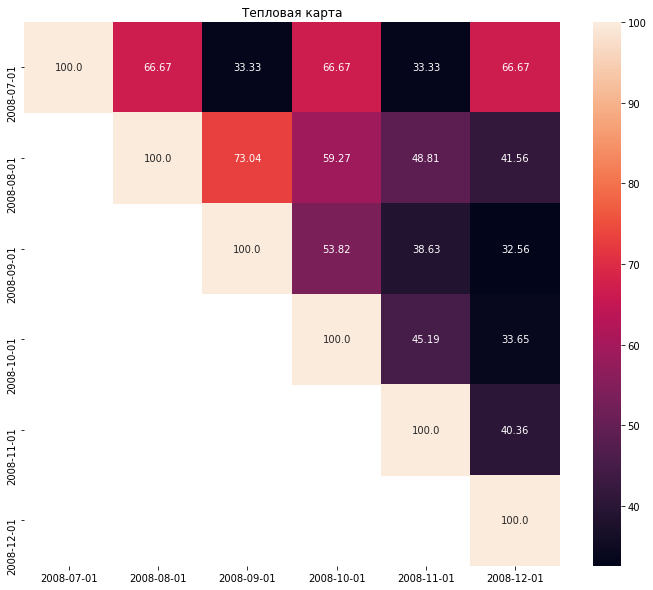

In [14]:
# постройте тепловую карту Retention Rate
df = pd.read_sql_query(query, con = engine) 
retention = df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(12, 10)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

# опишите аномалии или другие необычные явления и сформулируйте гипотезы
С каждым месяцем процент удержания новых пользователей в первый месяц становится меньше.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [15]:
# напишите запрос
query = '''
SELECT *,
       Round(( posts_count - Lag(posts_count)
                               over () ) :: NUMERIC / Lag(posts_count)
                                                        over () * 100, 2)
FROM   (SELECT To_char(creation_date, 'MM') :: INT creation_month,
               Count(1)                            posts_count
        FROM   stackoverflow.posts
        WHERE  To_char(creation_date, 'MM') > '08'
        GROUP  BY creation_month)a 
'''

# выполните запрос
pd.read_sql_query(query, con=engine)

,creation_month,posts_count,round
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

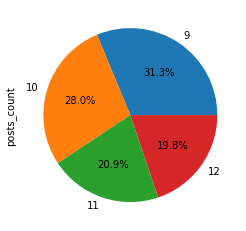

In [16]:
# постройте круговую диаграмму с количеством постов по месяцам
df = pd.read_sql_query(query, con=engine)
df['posts_count'].plot.pie(label='posts_count', autopct='%1.1f%%',labels=df.creation_month);

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [17]:
# напишите запрос
query = '''
SELECT DISTINCT *
FROM            (
                       SELECT week_creation,
                              MAX(creation_date) OVER (partition BY week_creation)
                       FROM   (
                                     SELECT Date_part('week',creation_date)::int week_creation,
                                            creation_date
                                     FROM   stackoverflow.posts
                                     WHERE  user_id IN
                                            (
                                                     SELECT   user_id
                                                     FROM     stackoverflow.posts
                                                     GROUP BY user_id
                                                     ORDER BY count(1) DESC limit 1)
                                     AND    date_part('month',creation_date) = '10')a)a
'''

# выполните запрос
pd.read_sql_query(query, con=engine)

,week_creation,max
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
